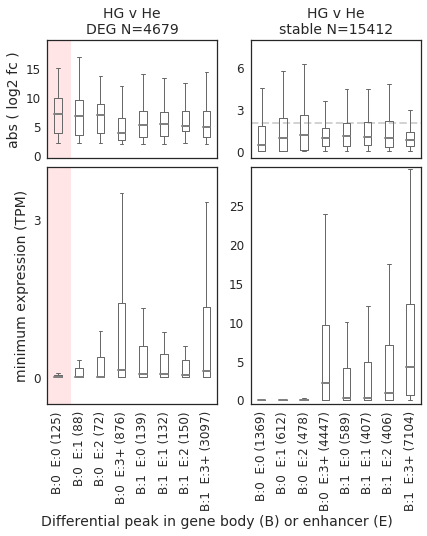

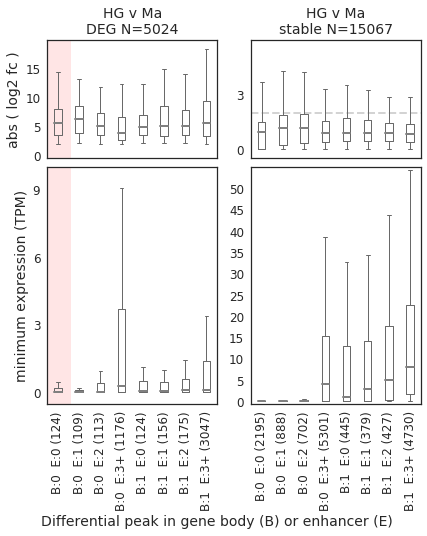

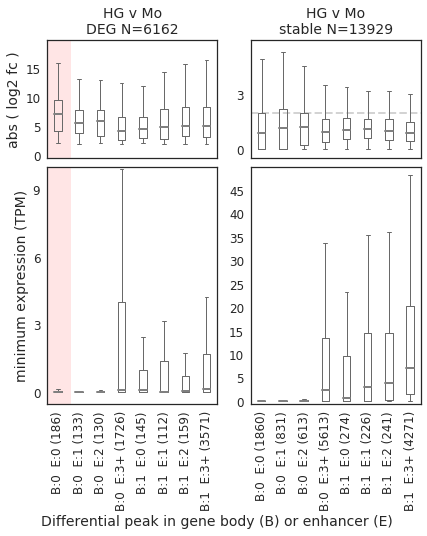

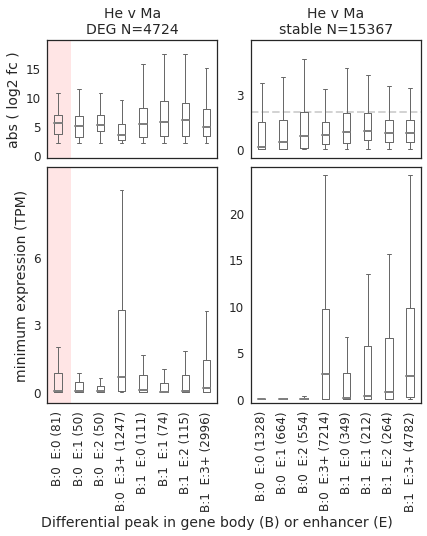

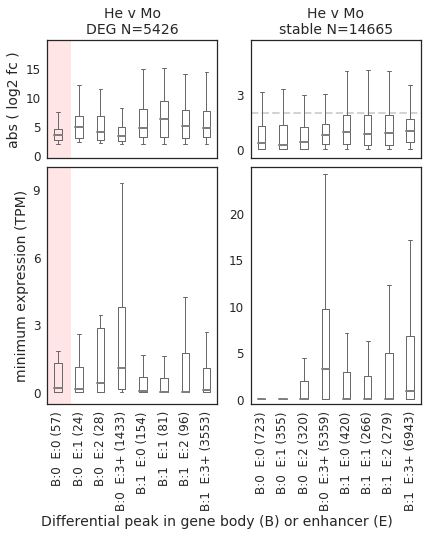

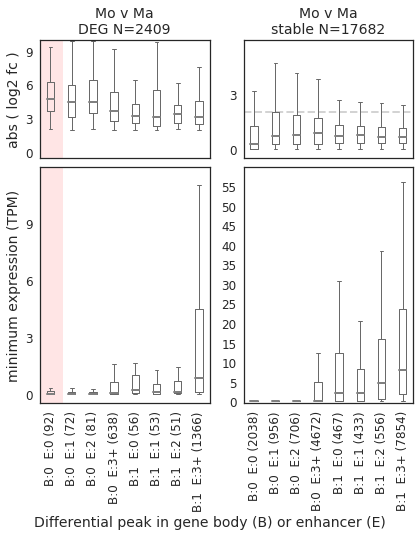

In [3]:
%matplotlib inline

import os as os
import collections as col
import itertools as itt
import pickle as pck
import csv as csv
import json as js
import time as ti

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import numpy as np
import numpy.random as rng
import scipy.stats as stats
import pandas as pd
import seaborn as sns

# What does this do?
# Plot boxplots of minimum TPM
# log2 fold-change for genes
# stratified by PePr hits
# (body/enhancer)

date = '20180921'

run_plot_gene_enh_pepr = True

save_figures = False

journal = 'bmc_genbio'
res = 'print_lo'
fig_sizes = js.load(open('/home/pebert/work/code/mpggit/statediff/annotation/misc/fig_sizes.json'))
fig_sizes = fig_sizes[journal]
resolution = fig_sizes['resolution']

segmentations = ['cmm18', 'esc18', 'ecs10']
scorings = ['penem', 'ordem', 'penrep', 'ordrep']

sns.set(style='white',
        font_scale=1.5,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis/projects/statediff'
cache_dir = os.path.join(fhgfs_base, 'caching/notebooks')

isect_folder = os.path.join(fhgfs_base, 'bedtools/deep/isect_any_pepr')

tpm_file = os.path.join(fhgfs_base, 'salmon', 'deep', 'agg_gene_tpm.h5')

base_out = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/statediff'

fig_supp = os.path.join(base_out, 'figures', 'pub', 'supp')
fig_main = os.path.join(base_out, 'figures', 'pub', 'main')
fig_collect = os.path.join(base_out, 'figures', 'pub', 'collection')
                   


def extract_table_header(fpath):
    peak_header = ['chrom', 'start', 'end', 'name', 'fc', 'strand',
                   'signal', 'pv', 'qv']
    peak_header = ['peak_' + h for h in peak_header]
    with open(fpath, 'r') as table:
        hd = table.readline().strip('#').strip().split('\t')
    header = hd + peak_header + ['overlap']
    return header
    

def load_gene_ovl_table(fpath, hit_type, header):
    
    if header is None:
        header = extract_table_header(fpath)
    
    records = dict()
    with open(fpath, 'r', newline='') as table:
        _ = table.readline()
        reader = csv.DictReader(table, delimiter='\t',
                                fieldnames=header)
        for row in reader:
            try:
                gene = records[row['name']]
            except KeyError:
                gene = {'name': row['name'], 'symbol': row['symbol'],
                        'log2fc': row['log2fc'], 'is_de': row['is_de'],
                        'baseMean': row['baseMean'], hit_type: 0, 'padj': row['padj']}
                records[row['name']] = gene
            if int(row['overlap']) > 0:
                gene[hit_type] += 1
    df = pd.DataFrame.from_records(list(records.values()), index='name')
    df['log2fc'] = df['log2fc'].astype(np.float32)
    df['is_de'] = df['is_de'].astype(np.int8)
    df['padj'] = df['padj'].astype(np.float32)
    return df, header
    

def load_enhancer_ovl_table(fpath1, smp1, fpath2, smp2, header):
    
    if header is None:
        header = extract_table_header(fpath1)
    
    genes = dict()
    for fp, smp in zip([fpath1, fpath2], [smp1, smp2]):
        with open(fp, 'r') as table:
            _ = table.readline()
            reader = csv.DictReader(table, delimiter='\t', fieldnames=header)
            for row in reader:
                try:
                    gene = genes[row['name']]
                except KeyError:
                    gene = {'name': row['name'], 'enhancer': set(),
                            smp1: set(), smp2: set()}
                    genes[row['name']] = gene
                gene['enhancer'].add((row['GHid'], int(row['intragenic'])))
                if int(row['overlap']) > 0:
                    gene[smp].add((row['GHid'], int(row['intragenic'])))
                
    for k, v in genes.items():
        v['total_enh'] = len(v['enhancer'])
        v['intra_enh'] = sum([t[1] for t in v['enhancer']])
        v['inter_enh'] = v['total_enh'] - v['intra_enh']
        
        # individual hits
        v[smp1 + '_' + 'total'] = len(v[smp1])
        v[smp2 + '_' + 'total'] = len(v[smp2])
        v[smp1 + '_' + 'intra'] = len([t for t in v[smp1] if t[1] == 1])
        v[smp2 + '_' + 'intra'] = len([t for t in v[smp2] if t[1] == 1])
        v[smp1 + '_' + 'inter'] = v[smp1 + '_' + 'total'] - v[smp1 + '_' + 'intra']
        v[smp2 + '_' + 'inter'] = v[smp2 + '_' + 'total'] - v[smp2 + '_' + 'intra']
        
        # common hits
        v['both_total'] = len(v[smp1].intersection(v[smp2]))
        v['both_intra'] = len(set([t for t in v[smp1] if t[1] == 1]).intersection([t for t in v[smp2] if t[1] == 1]))
        v['both_inter'] = len(set([t for t in v[smp1] if t[1] == 0]).intersection([t for t in v[smp2] if t[1] == 0]))
             
        # differential hits
        hit_enh = len(v[smp1].union(v[smp2]))
        assert 0 <= hit_enh <= v['total_enh'], 'Too many hit enhancers'
        v['diff_total'] = hit_enh - v['both_total']
        
        intra_enh = len(set([t for t in v[smp1] if t[1] == 1]).union([t for t in v[smp2] if t[1] == 1]))
        v['diff_intra'] = intra_enh - v['both_intra']
        assert 0 <= intra_enh <= v['intra_enh'], 'Too many intra enhancers'
        
        inter_enh = len(set([t for t in v[smp1] if t[1] == 0]).union([t for t in v[smp2] if t[1] == 0]))
        v['diff_inter'] = inter_enh - v['both_inter']
        assert 0 <= inter_enh <= v['inter_enh'], 'Too many inter enhancers'
            
        del v['enhancer']
        del v[smp1]
        del v[smp2]
                
    df = pd.DataFrame.from_records(list(genes.values()), index='name')
    df = df.astype(np.int32)
    return df, header
    
                
def load_expression_data(s1, s2, select_genes):
    
    with pd.HDFStore(tpm_file, 'r') as hdf:
        load_keys = [k for k in hdf.keys() if k.endswith(s1) or k.endswith(s2)]
        assert len(load_keys) == 2, 'data missing'
        data = pd.concat([hdf[load_keys[0]], hdf[load_keys[1]]], axis=1, ignore_index=False)
        data['min_tpm'] = data.min(axis=1)
        data['max_tpm'] = data.max(axis=1)
        data['mean_tpm'] = data.mean(axis=1)
        data = data.loc[data.index.isin(select_genes), ['min_tpm', 'max_tpm', 'mean_tpm']].copy()
    return data

def get_partner_file(fpath, partner):
    
    if partner == 'promoter':
        partner_path = fpath.replace('gene_ovl_', 'prom_ovl_')
        partner_path = partner_path.replace('H3K36me3', 'H3K4me3')
    elif partner == 'enhancer':
        partner_path = fpath.replace('gene_ovl_', 'enh_ovl_')
        partner_path = partner_path.replace('H3K36me3', 'H3K27ac')
    else:
        raise ValueError('Unexpect partner file {}'.format(partner))
    return partner_path        

    
def cache_overlap_data(rootfolder, cache_file):
    """
    """
    gene_header = None
    enh_header = None
    select_genes = None
    done = set()
    for gene_ovl in sorted(os.listdir(rootfolder)):
        if not gene_ovl.startswith('gene_ovl'):
            continue
        if not gene_ovl.endswith('.tsv'):
            continue
        _, _, sample1, comp = gene_ovl.split('.')[0].split('_', 3)
        if comp in done:
            continue
        done.add(comp)
        s1, s2 = comp.split('_vs_')
        if s1 in sample1:
            sample2 = sample1.replace(s1, s2)
        else:
            sample2 = sample1.replace(s2, s1)
                        
        gene_ovl_s1 = os.path.join(rootfolder, gene_ovl)
        genes, gene_header = load_gene_ovl_table(gene_ovl_s1, sample1, gene_header)
        
        gene_ovl_s2 = os.path.join(rootfolder, gene_ovl.replace(sample1, sample2))
        tmp, gene_header = load_gene_ovl_table(gene_ovl_s2, sample2, gene_header)
        
        genes = genes.merge(tmp.loc[:, [sample2]].copy(), how='outer',
                            left_index=True, right_index=True)
                
        sample1 = sample1.replace('H3K36me3', 'H3K4me3')
        sample2 = sample2.replace('H3K36me3', 'H3K4me3')
        
        prom_ovl_s1 = get_partner_file(gene_ovl_s1, 'promoter')
        tmp, gene_header = load_gene_ovl_table(prom_ovl_s1, sample1, gene_header)
        genes = genes.merge(tmp.loc[:, [sample1]].copy(), how='outer',
                            left_index=True, right_index=True)
        
        prom_ovl_s2 = prom_ovl_s1.replace(sample1, sample2)
        tmp, gene_header = load_gene_ovl_table(prom_ovl_s2, sample2, gene_header)
        genes = genes.merge(tmp.loc[:, [sample2]].copy(), how='outer',
                            left_index=True, right_index=True)
                
        sample1 = sample1.replace('H3K4me3', 'H3K27ac')
        sample2 = sample2.replace('H3K4me3', 'H3K27ac')
        
        enh_ovl_s1 = get_partner_file(gene_ovl_s1, 'enhancer')
        enh_ovl_s2 = enh_ovl_s1.replace(sample1, sample2)
                
        tmp, enh_header = load_enhancer_ovl_table(enh_ovl_s1, sample1,
                                                  enh_ovl_s2, sample2,
                                                  enh_header)

        genes = genes.merge(tmp, how='outer', left_index=True, right_index=True)
                
        if select_genes is None:
            # select only genes on 1-22,X
            select_genes = set(genes.index)

        tpm_data = load_expression_data(s1, s2, select_genes)
        
        genes = genes.merge(tpm_data, how='outer', left_index=True, right_index=True)
        
        # genes w/o annotated enhancers have N/A after merge
        genes.fillna(0, inplace=True)
        
        assert genes.shape[0] == 20091, 'Genes missing for {}: {}'.format(gene_ovl, genes.shape[0])

        with pd.HDFStore(cache_file, 'a') as hdf:
            hdf.put(comp, genes, format='fixed')
            
    return cache_file

    
def prepare_plot_data(data, data_type, s1, s2):
    
    boxes = []
    box_labels = []
    s1b = s1 + '-H3K36me3'
    s2b = s2 + '-H3K36me3'
    s1e = s1 + '-H3K27ac'
    s2e = s2 + '-H3K27ac'
    
    # genes w/o chromatin changes
    # in gene body
    select_b0 = np.logical_and(data[s1b] == 0, data[s2b] == 0)
    select_b1 = np.logical_and(data[s1b] > 0, data[s2b] > 0)
    select_b = np.logical_or(select_b0, select_b1)
    
    select = np.logical_and(select_b, data['diff_total'] == 0)
    sub = data.loc[select, data_type].abs()
    boxes.append(sub)
    box_labels.append('B:0  E:0 ({})'.format(sub.size))
    
    # genes w/o diff body hit AND 1 diff. enhancer hit
    select = np.logical_and(select_b, data['diff_total'] == 1)
    sub = data.loc[select, data_type].abs()
    boxes.append(sub)
    box_labels.append('B:0  E:1 ({})'.format(sub.size))
    
    select = np.logical_and(select_b, data['diff_total'] == 2)
    sub = data.loc[select, data_type].abs()
    boxes.append(sub)
    box_labels.append('B:0  E:2 ({})'.format(sub.size))
    
    select = np.logical_and(select_b, data['diff_total'] >= 3)
    sub = data.loc[select, data_type].abs()
    boxes.append(sub)
    box_labels.append('B:0  E:3+ ({})'.format(sub.size))
    
    # genes w/ chromatin changes
    # in gene body
    select_b0 = np.logical_and(data[s1b] == 0, data[s2b] > 0)
    select_b1 = np.logical_and(data[s1b] > 0, data[s2b] == 0)
    select_b = np.logical_or(select_b0, select_b1)
    # genes with at least one body hit
    select = np.logical_and(select_b, data['diff_total'] == 0)
    sub = data.loc[select, data_type].abs()
    boxes.append(sub)
    box_labels.append('B:1  E:0 ({})'.format(sub.size))
    
    select = np.logical_and(select_b, data['diff_total'] == 1)
    sub = data.loc[select, data_type].abs()
    boxes.append(sub)
    box_labels.append('B:1  E:1 ({})'.format(sub.size))
    
    select = np.logical_and(select_b, data['diff_total'] == 2)
    sub = data.loc[select, data_type].abs()
    boxes.append(sub)
    box_labels.append('B:1  E:2 ({})'.format(sub.size))
    
    select = np.logical_and(select_b, data['diff_total'] >= 3)
    sub = data.loc[select, data_type].abs()
    boxes.append(sub)
    box_labels.append('B:1  E:3+ ({})'.format(sub.size))
    
    return boxes, box_labels
    
    
def generate_bins(dataset, stepsize):
    """
    """
    fc_min = dataset['log2fc'].min()
    assert fc_min < 0, 'That is unexpected...'
    fc_lower = (fc_min // stepsize) * stepsize - stepsize
    fc_max = dataset['log2fc'].max()
    fc_upper = (fc_max // stepsize) * stepsize + stepsize
    bins = np.arange(fc_lower, fc_upper + 0.1, stepsize)
    bin_num = [i for i, b in enumerate(bins, start=1)]
    return bins, bin_num
    

def compute_densities(dataset, bins, hit_type):
    
    histograms = []
    labels = []
    lo_bounds = [0, 2, 5, 8, 11]
    hi_bounds = [0, 3, 6, 9, 1000]
    # no overlap
    for lo, hi in zip(lo_bounds, hi_bounds):
        select = np.logical_and(dataset[hit_type] >= lo, dataset[hit_type] <= hi)
        group = dataset.loc[select, 'log2fc']
        if group.size == 0:
            hist = np.zeros_like(histograms[0])
            histograms.append(hist)
        else:
            hist, bin_edges = np.histogram(group, bins, density=True)
            histograms.append(np.concatenate([[0], hist]))
        if lo == 0:
            labels.append('0: {}'.format(group.size))
        elif lo == max(lo_bounds):
            labels.append('{}+: {}'.format(lo, group.size))
        else:
            labels.append('{}-{}: {}'.format(lo, hi, group.size))
    
    return histograms, labels
    
    
    
def create_cdf_plot(datapoints, comp, fkey):
    
    fig, axes = plt.subplots(figsize=fig_sizes['two_col']['square'],
                             nrows=3, ncols=2,
                             sharex=False, sharey=False)
    stepsize = 0.5
    bins, bin_nums = generate_bins(datapoints, stepsize)
    
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    
    data_colors = ['dimgrey', 'dodgerblue', 'limegreen', 'orange', 'magenta']
    
    # for all enhancers
    total_hist, total_labels = compute_densities(datapoints, bins, 'total_hits')
    # for intragenic
    intra_hist, intra_labels = compute_densities(datapoints, bins, 'intra_hits')
    # for intragenic
    inter_hist, inter_labels = compute_densities(datapoints, bins, 'inter_hits')
    row_title = {0: 'anywhere', 1: 'intragenic', 2: 'intergenic'}
    
    s1, s2 = comp.split('_vs_')
    for row_idx, (data, lab) in enumerate([(total_hist, total_labels),
                                           (intra_hist, intra_labels),
                                           (inter_hist, inter_labels)]):
        ax = axes[row_idx, 0]
        if row_idx == 0:
            tt = ax.set_title('HSP gene enhancer hits: {} v {}'.format(s1, s2), fontsize=14)
            tt.set_position((1, 1))
        
        leg_handles = []
        for c, hist, l in zip(data_colors, data, lab):
            if c == 'dimgrey':
                style = 'dashed'
                zorder = 0
            else:
                style = 'solid'
                zorder = 2
            assert np.isclose(hist.sum() * stepsize, 1., atol=1e-6), 'CDF not 1'
            ax.plot(bins, np.cumsum(hist) * stepsize,
                    lw=2, ls=style, c=c, zorder=zorder,
                    label=l)
#             ax.axhline(0.75, 0, 1, c='lightgrey',
#                        ls='dashed', zorder=0, lw=1)
#             ax.axhline(0.5, 0, 1, c='lightgrey',
#                        ls='dashed', zorder=0, lw=1)
#             ax.axhline(0.25, 0, 1, c='lightgrey',
#                        ls='dashed', zorder=0, lw=1)
            
            ax.axvline(-3, 0, 1, c='black', alpha=0.5,
                       ls='dashed', zorder=0, lw=1)
            ax.axvline(3, 0, 1, c='black', alpha=0.5,
                       ls='dashed', zorder=0, lw=1)
            leg_patch = mlines.Line2D([], [], marker='s', markersize=7,
                                      lw=0, color=c, label=l)
            leg_handles.append(leg_patch)
        
        if comp == 'HG_vs_Mo':
            ax_leg = ax.legend(loc='right', handles=leg_handles,
                               fontsize=10, bbox_to_anchor=(1.05, 0.4))
        else:
            ax_leg = ax.legend(loc='best', handles=leg_handles,
                               fontsize=10)
        tt = ax_leg.set_title(row_title[row_idx], prop={'size': 12})
        
        if row_idx == 1:
            ax.set_ylabel('Cumulative probability', fontsize=14)
                
        if row_idx == 2:
            neg_ticks = np.arange(0, bins.min(), -10)[::-1]
            pos_ticks = np.arange(0, bins.max(), 10)

            x_ticks = np.concatenate([neg_ticks, pos_ticks[1:]])
            x_ticks = x_ticks.astype(np.int8)
            ax.set_xticks(x_ticks)
            ax.set_xticklabels(map(str, x_ticks), fontsize=12)
            tt = ax.set_xlabel('Gene expression fold change (log2)', fontsize=14)
            tt.set_position((1, 0))
        else:
            ax.set_xticks([])
            
        ax.set_xlim(bins.min(), bins.max())

        y_ticks = [0., 0.5, 1]
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(map(str, y_ticks), fontsize=12)
        ax.set_ylim(-0.05, 1.05)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

            
        ax = axes[row_idx, 1]
        
        for c, hist in zip(data_colors, data):
            if c == 'dimgrey':
                style = 'dashed'
                zorder = 0
            else:
                style = 'solid'
                zorder = 2
            assert np.isclose(hist.sum() * stepsize, 1., atol=1e-6), 'CDF not 1'
            ax.plot(bins, np.cumsum(hist) * stepsize,
                    lw=2, ls=style, c=c, zorder=zorder)
            ax.axhline(0.75, 0, 1, c='lightgrey',
                       ls='dashed', zorder=0, lw=1)
            ax.axhline(0.5, 0, 1, c='lightgrey',
                       ls='dashed', zorder=0, lw=1)
            ax.axhline(0.25, 0, 1, c='lightgrey',
                       ls='dashed', zorder=0, lw=1)
            
            ax.axvline(-3, 0, 1, c='black', alpha=0.5,
                       ls='dashed', zorder=0, lw=1)
            ax.axvline(3, 0, 1, c='black', alpha=0.5,
                       ls='dashed', zorder=0, lw=1)
            
        ax.set_yticks([])
        if row_idx == 2:
            x_ticks = [-3, 0, 3]
            ax.set_xticks(x_ticks)
            ax.set_xticklabels(map(str, x_ticks), fontsize=12)
        else:
            ax.set_xticks([])
        
        ax.set_xlim(-5, 5)
        #ax.set_ylim(-0.05, 1.05)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    return fig, []
    
    
def create_boxplot(datapoints, comp, fkey):
    """
    """
    boxcolor = 'dimgrey'
    medcolor = 'grey'
    median_props = {'color': medcolor, 'linewidth': 2}
    box_props = {'color': boxcolor, 'linewidth': 1}
    whisker_props = {'color': boxcolor, 'linewidth': 1}
    cap_props = {'color': boxcolor, 'linewidth': 1}
        
    
    fig, axes = plt.subplots(figsize=fig_sizes['two_col']['square'],
                             nrows=2, ncols=2, sharex=False, sharey=False,
                             gridspec_kw={'height_ratios': [1, 2]})
    data_lut = {(0, 0): ('diff', 'log2fc'), (0, 1): ('stable', 'log2fc'),
                (1, 0): ('diff', 'min_tpm'), (1, 1): ('stable', 'min_tpm')}
        
    plt.subplots_adjust(hspace=0.05, wspace=0.2)
    s1, s2 = comp.split('_vs_')
    for row in range(2):
        for col in range(2):
            ax = axes[row, col]
            gene_type, data_type = data_lut[(row, col)]
            
            if gene_type == 'diff':
                subset = datapoints.loc[datapoints['is_de'] == 1, :].copy()
            else:
                subset = datapoints.loc[datapoints['is_de'] < 1, :].copy()
            
            if row == 0 and col == 0:
                ax.set_title('{} v {}\nDEG N={}'.format(s1, s2, subset.shape[0]),
                             fontsize=14)
                ax.set_ylabel('abs ( log2 fc )', fontsize=14)
            elif row == 0 and col == 1:
                ax.set_title('{} v {}\nstable N={}'.format(s1, s2, subset.shape[0]),
                             fontsize=14)
                ax.axhline(2, 0, 1, lw=2, ls='dashed',
                           color='lightgrey', zorder=0)
            else:
                pass
            
            if row == 1 and col == 0:
                ax.set_ylabel('minimum expression (TPM)', fontsize=14)
                xl_pos = ax.set_xlabel('Differential peak in gene body (B) or enhancer (E)', fontsize=14)
                xl_pos.set_position((1, 0))
                                    
            boxes, boxlabels = prepare_plot_data(subset, data_type, s1, s2)
                        
            ax.set_xlim(0, len(boxes) + 1)
                       
            bb = ax.boxplot(boxes, sym="", labels=None, widths=0.35,
                            medianprops=median_props, boxprops=box_props,
                            whiskerprops=whisker_props, capprops=cap_props)
            max_y = 0
            for cap in bb['caps']:
                max_y = max(max_y, cap.get_ydata()[0])
            if max_y < 12:
                ax.set_ylim(-0.5, max_y // 2 * 2 + 2)
                yticks = np.arange(0, np.ceil(max_y), 3, dtype=np.int8)
            else:
                ax.set_ylim(-0.5, max_y // 5 * 5 + 5)
                yticks = np.arange(0, np.ceil(max_y), 5, dtype=np.int8)
            
            ax.set_yticks(yticks)
            ax.set_yticklabels(map(str, yticks), fontsize=12)
            
            if row == 0:
                ax.set_xticks([])
            if row == 1:
                ax.set_xticklabels(boxlabels, fontsize=12, rotation=90)
            if col == 0:
                ax.axvline(1, 0, 1, lw=25, ls='solid', color='red',
                           alpha=0.1, zorder=0)
            
    return fig, []

            
def plot_gene_enh_pepr_ovl():
    cache_file = os.path.join(cache_dir, '{}_plot_gene-enh-pepr_tpm-bin.h5'.format(date))
    #os.unlink(cache_file)
    if not os.path.isfile(cache_file):
        _ = cache_overlap_data(isect_folder, cache_file)
    elif os.stat(cache_file).st_size < 10e2:
        _ = cache_overlap_data(isect_folder, cache_file)
    else:
        print('Assuming cache file is valid')
    
    with pd.HDFStore(cache_file, 'r') as hdf:
        for k in hdf.keys():
            comp = k.split('/')[-1]
            data = hdf[k]               

            subfolder = fig_collect
            fk = 'X'
            
            fig, exart = create_boxplot(data, comp, fk)                    
            if save_figures:
                outname = 'fig_{}_gene-enh-pepr_tpm-box_{}'.format(fk, comp)

                out_pdf = os.path.join(subfolder, outname + '.pdf')
                fig.savefig(out_pdf, bbox_inches='tight', extra_artists=exart)
                out_png = os.path.join(subfolder, outname + '.png')
                fig.savefig(out_png, bbox_inches='tight', extra_artists=exart, dpi=resolution[res])

#             fig, exart = create_cdf_plot(data, comp, fk)                    
#             if save_figures:
#                 outname = 'fig_{}_gene-enh-hsp_tpm-cdf_{}_{}_{}'.format(fk, seg, scoring, comp)

#                 out_pdf = os.path.join(subfolder, outname + '.pdf')
#                 fig.savefig(out_pdf, bbox_inches='tight', extra_artists=exart)
#                 out_png = os.path.join(subfolder, outname + '.png')
#                 fig.savefig(out_png, bbox_inches='tight', extra_artists=exart, dpi=resolution[res])
    return 0



    
if run_plot_gene_enh_pepr:
    plot_gene_enh_pepr_ovl()

    